In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import tensorflow as tf
import os
from matplotlib import pyplot as plt
from tensorflow.keras import layers, models, datasets
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
(X_train, _ ), (X_test, _ ) = datasets.mnist.load_data()

In [4]:
X_train.shape
X_test.shape

(60000, 28, 28)

(10000, 28, 28)

In [5]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [6]:
X_train = X_train.reshape(X_train.shape[0],28,28,1)
X_test = X_test.reshape(X_test.shape[0],28,28,1)

In [7]:
X_train.shape
X_test.shape

(60000, 28, 28, 1)

(10000, 28, 28, 1)

## Making DC Autoencoder Model

In [8]:
input_layer = layers.Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]), name='input_layer')


# Encoder
x = layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu')(input_layer)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(x)
encoded_layer = layers.MaxPooling2D((2, 2), padding='same', name='encoded_layer')(x)


# Decoder
x = layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(encoded_layer)
x = layers.UpSampling2D((2, 2))(x)

x = layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)

x = layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)

decoded_layer = layers.Conv2D(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same', name='decoded_layer')(x)


# Define the model
model = models.Model(inputs=input_layer, outputs=decoded_layer, name='DCautoencoder')
model.summary()


Model: "DCautoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoded_layer (MaxPooling2D)    │ (None, 4, 4, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoded_layer (Conv2D)          │ (None, 28, 28, 1)      │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
encoder = models.Model(inputs = input_layer, outputs = encoded_layer, name ='encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoded_layer (MaxPooling2D)    │ (None, 4, 4, 8)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,904 (7.44 KB)

 Trainable params: 1,904 (7.44 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
decoder = models.Model(inputs = encoded_layer, outputs = decoded_layer, name = 'decoder')
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ keras_tensor_5CLONE             │ (None, 4, 4, 8)        │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoded_layer (Conv2D)          │ (None, 28, 28, 1)      │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,481 (9.69 KB)

 Trainable params: 2,481 (9.69 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam')

### Training model

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os

checkpoint_path = "checkpoints/DCAutoEncoder/cp-{epoch:04d}.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_freq='epoch',  # Saving every epoch
    verbose=1)


In [17]:
epochs = 50
batch_size = 128

training = 1  # Set to 0 when resuming training

if training:
    history = model.fit(
        X_train, X_train,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[checkpoint_callback],
        validation_data = (X_test,X_test), 
        verbose=1
    )
    
# To resume training from the last checkpoint if training is set to 0
#training == 0
else:                                                
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
    
    if latest_checkpoint:
        model.load_weights(latest_checkpoint)
        print(f"Loaded model weights from {latest_checkpoint}")
    else:
        print("No checkpoint found, starting training from scratch.")
    training = 1  # Reset training to 1 to continue the training process


Epoch 1/50
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1025
Epoch 1: saving model to checkpoints/DCAutoEncoder/cp-0001.weights.h5
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - loss: 0.1025 - val_loss: 0.0982
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0992
Epoch 2: saving model to checkpoints/DCAutoEncoder/cp-0002.weights.h5
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0992 - val_loss: 0.0978
Epoch 3/50
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0987
Epoch 3: saving model to checkpoints/DCAutoEncoder/cp-0003.weights.h5
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0987 - val_loss: 0.0975
Epoch 4/50
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0985
Epoch 4: saving model to checkpoints/DCAutoEncoder/cp-0004.weights.h5
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0985 - val_loss: 0.0973
Epoch 5/50
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0982
Epoch 5: saving model to checkpoints/DCAutoEncoder/cp-0005.weights.h5
469/

Text(0.5, 1.0, 'loss while training DCautoencoder for epochs=50 and batch_size=128')

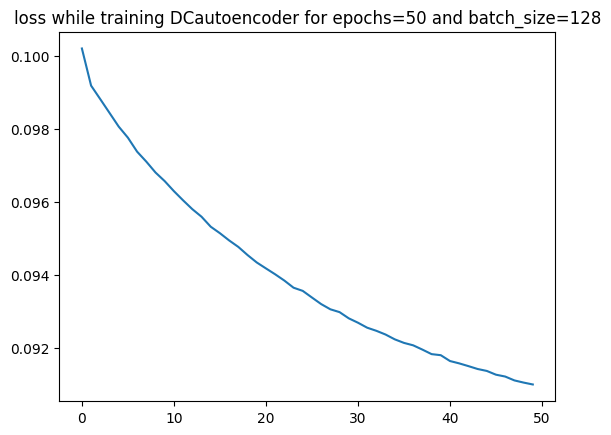

In [18]:
plt.plot(history.history['loss'])
plt.title(f"loss while training DCautoencoder for epochs={epochs} and batch_size={batch_size}")
plt.show()

## Generating images for testing dataset

In [19]:
batch_size = 256
encoded_data = encoder.predict(X_test, batch_size = batch_size)
encoded_data.shape    

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


(10000, 4, 4, 8)

In [20]:
decoded_data = decoder.predict(encoded_data, batch_size = batch_size)
decoded_data.shape   

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


(10000, 28, 28, 1)

Text(0.5, 1.0, 'Generated image')

(-0.5, 27.5, 27.5, -0.5)

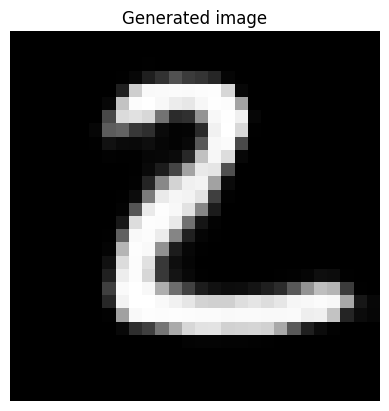

Text(0.5, 1.0, 'Testing image')

(-0.5, 27.5, 27.5, -0.5)

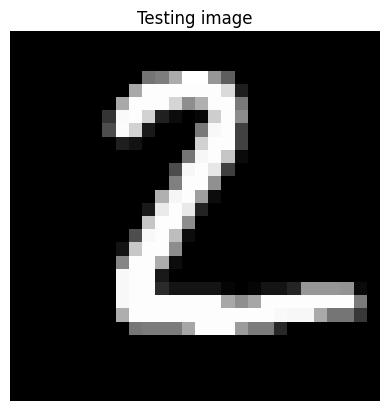

In [21]:
i = 1
plt.imshow(decoded_data[i], cmap = 'gray')
plt.title("Generated image")
plt.axis('off')
plt.show()
plt.imshow(X_test[i], cmap = 'gray')
plt.title("Testing image")
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


<Figure size 1200x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Original Image')

(-0.5, 27.5, 27.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Generated Image')

(-0.5, 27.5, 27.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Original Image')

(-0.5, 27.5, 27.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Generated Image')

(-0.5, 27.5, 27.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Original Image')

(-0.5, 27.5, 27.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Generated Image')

(-0.5, 27.5, 27.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Original Image')

(-0.5, 27.5, 27.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Generated Image')

(-0.5, 27.5, 27.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Original Image')

(-0.5, 27.5, 27.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Generated Image')

(-0.5, 27.5, 27.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Original Image')

(-0.5, 27.5, 27.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Generated Image')

(-0.5, 27.5, 27.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Original Image')

(-0.5, 27.5, 27.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Generated Image')

(-0.5, 27.5, 27.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Original Image')

(-0.5, 27.5, 27.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Generated Image')

(-0.5, 27.5, 27.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Original Image')

(-0.5, 27.5, 27.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Generated Image')

(-0.5, 27.5, 27.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Original Image')

(-0.5, 27.5, 27.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Generated Image')

(-0.5, 27.5, 27.5, -0.5)

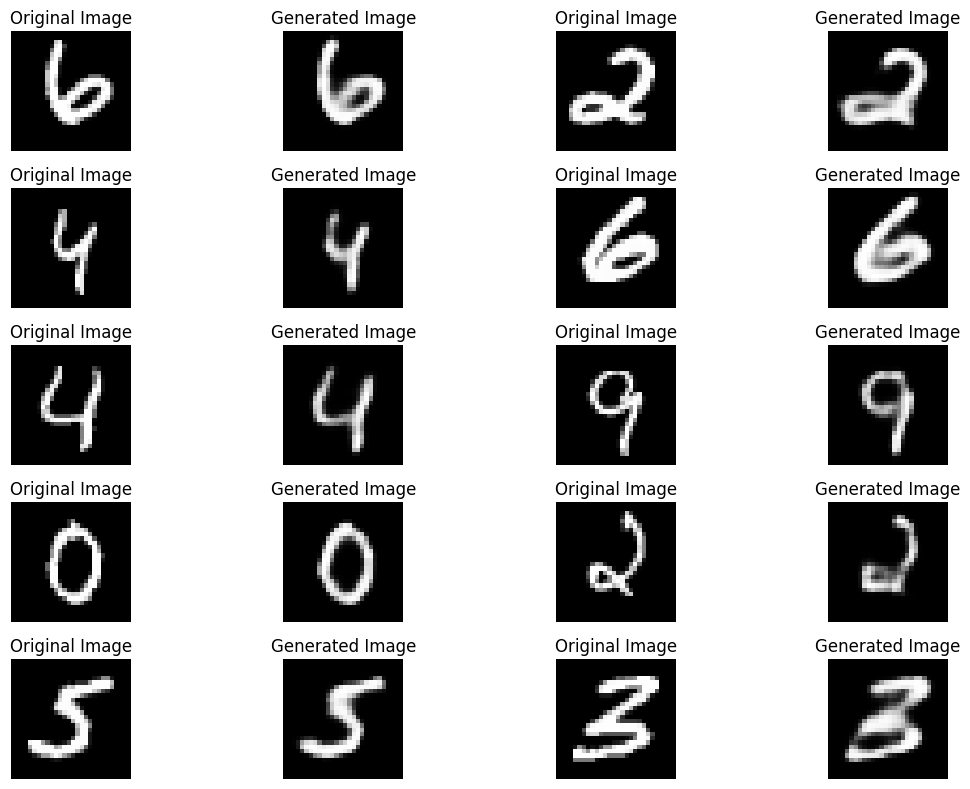

In [29]:
import numpy as np

# Choose 10 random indices from the test data
indices = np.random.randint(0, len(X_test), 10)  # Adjust as needed

# Select images from the test data
test_images = X_test[indices]

# Generate reconstructed images using the decoder model
encoded_imgs = encoder.predict(test_images)
reconstructed_images = decoder.predict(encoded_imgs)


# Plot original and reconstructed images
plt.figure(figsize=(12, 8))
for i in range(len(indices)):
    # Original image
    plt.subplot(5, 4, 2*i + 1)
    plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Reconstructed image
    plt.subplot(5, 4, 2*i + 2)
    plt.imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
    plt.title('Generated Image')
    plt.axis('off')

plt.tight_layout()
plt.show()

